In [1]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.9 MB/s eta 0:00:00:00:0100:01


In [2]:
import pandas as pd
import re
import numpy as np
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Loading and Inspecting the Dataset

In [14]:
import os

print(os.listdir())


['.config', 'sample_data']


In [13]:
data="HateSpeechData.xlsx"
dataset= pd.read_excel(data)

FileNotFoundError: [Errno 2] No such file or directory: 'HateSpeechData.xlsx'

In [ ]:
print("dataset shape:", dataset.shape)
dataset.head()

dataset shape: (35001, 7)


,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious
0,ভারতের ষড়যন্ত্রের শিকার সাকিববাংলাদেশ ক্রিকেট ...,1,1,0,0,1,0
1,টিম ডংসো হইছে সাল থেকেওয়ার্ল্ড কাপে তার প্রমান...,0,0,0,0,0,0
2,এক এক যুগে বাংলাদেশ একেকটা হিরোকে ধ্বংস করছে,0,0,0,0,0,0
3,নটির পোলা পাপন সব তোর খেলা,1,1,0,1,0,0
4,বাংলাদেশের মানুষ সবাই গর্জে ওঠো পাপনের বিরুদ্ধ...,0,0,0,0,0,0


Data Overview

In [ ]:
dataset.info()
print("\nMissing values per column:")
print(dataset.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35001 entries, 0 to 35000
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Comment      35000 non-null  object
 1   Hate/NoHate  35001 non-null  int64 
 2   Insult       35001 non-null  int64 
 3   Violence     35001 non-null  int64 
 4   Sexual       35001 non-null  int64 
 5   Racism       35001 non-null  int64 
 6   Religious    35001 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.9+ MB

Missing values per column:
1


In [ ]:
dataset.describe()

,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious
count,35001.000000,35001.000000,35001.000000,35001.000000,35001.000000,35001.000000
mean,0.398017,0.309705,0.093654,0.173824,0.062827,0.089226
std,0.489496,0.462379,0.291352,0.378963,0.242655,0.285074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Exploratory Data Analysis (EDA)
Target Variable Distribution

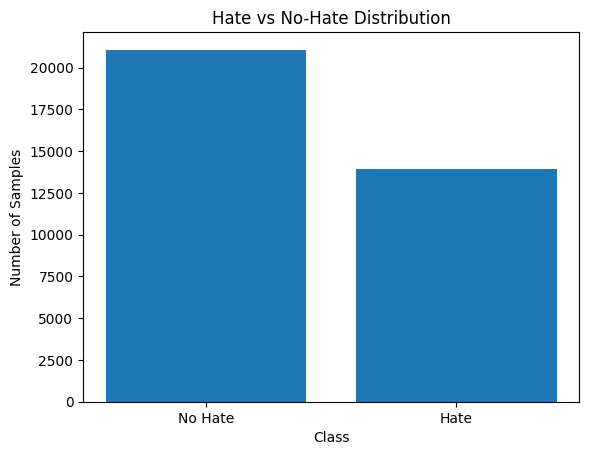

In [ ]:
import matplotlib.pyplot as plt

# Count hate vs no-hate
hate_counts = dataset['Hate/NoHate'].value_counts()

plt.figure()
plt.bar(['No Hate', 'Hate'], hate_counts.sort_index())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Hate vs No-Hate Distribution")
plt.show()

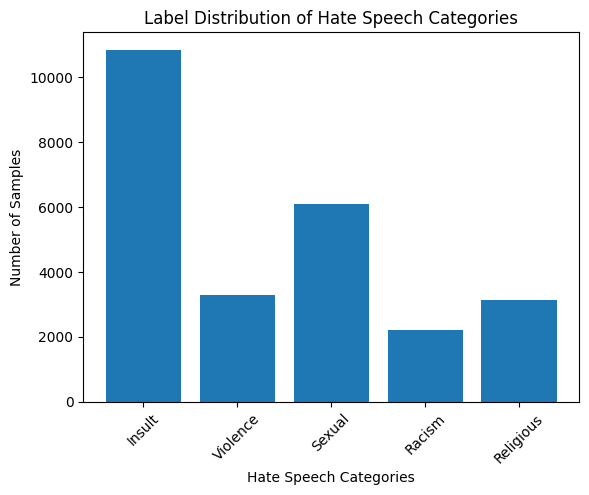

In [ ]:
label_cols = ['Insult', 'Violence', 'Sexual', 'Racism', 'Religious']
label_counts = dataset[label_cols].sum()

plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Hate Speech Categories")
plt.ylabel("Number of Samples")
plt.title("Label Distribution of Hate Speech Categories")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Print all column names
print(dataset.columns)


Index(['Comment', 'Hate/NoHate', 'Insult', 'Violence', 'Sexual', 'Racism',
       'Religious'],
      dtype='object')


/tmp/ipython-input-4112538052.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


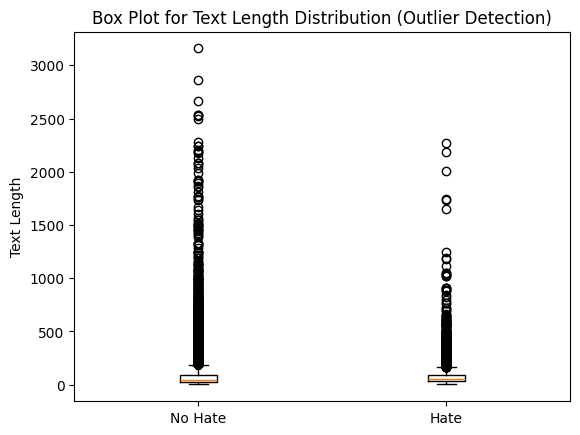

In [ ]:
import matplotlib.pyplot as plt

# Use original text column safely
dataset['text_length'] = dataset['Comment'].apply(lambda x: len(str(x)))

# Hate vs No Hate
hate_text_length = dataset[dataset['Hate/NoHate'] == 1]['text_length']
no_hate_text_length = dataset[dataset['Hate/NoHate'] == 0]['text_length']

plt.figure()
plt.boxplot(
    [no_hate_text_length, hate_text_length],
    labels=['No Hate', 'Hate'],
    showfliers=True
)

plt.ylabel("Text Length")
plt.title("Box Plot for Text Length Distribution (Outlier Detection)")
plt.show()


/tmp/ipython-input-2492699159.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


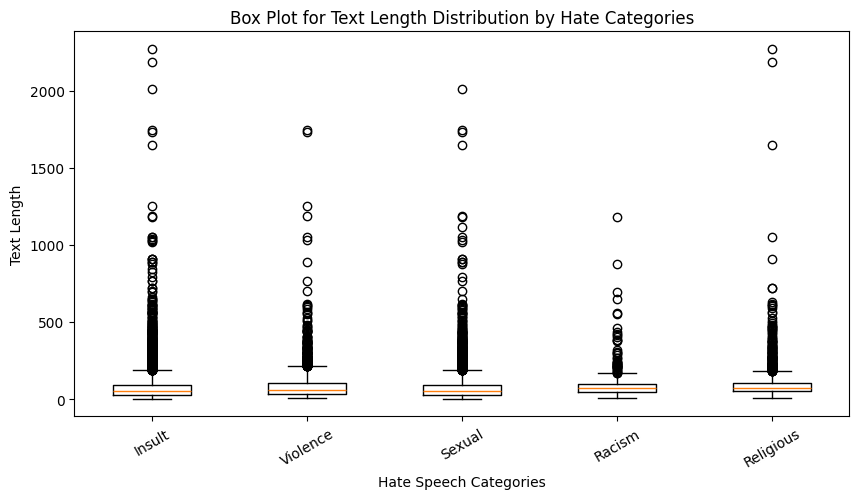

In [ ]:
label_cols = ['Insult', 'Violence', 'Sexual', 'Racism', 'Religious']
label_text_lengths = []

for label in label_cols:
    lengths = dataset[dataset[label] == 1]['text_length']
    label_text_lengths.append(lengths)

plt.figure(figsize=(10,5))
plt.boxplot(
    label_text_lengths,
    labels=label_cols,
    showfliers=True
)

plt.ylabel("Text Length")
plt.xlabel("Hate Speech Categories")
plt.title("Box Plot for Text Length Distribution by Hate Categories")
plt.xticks(rotation=30)
plt.show()


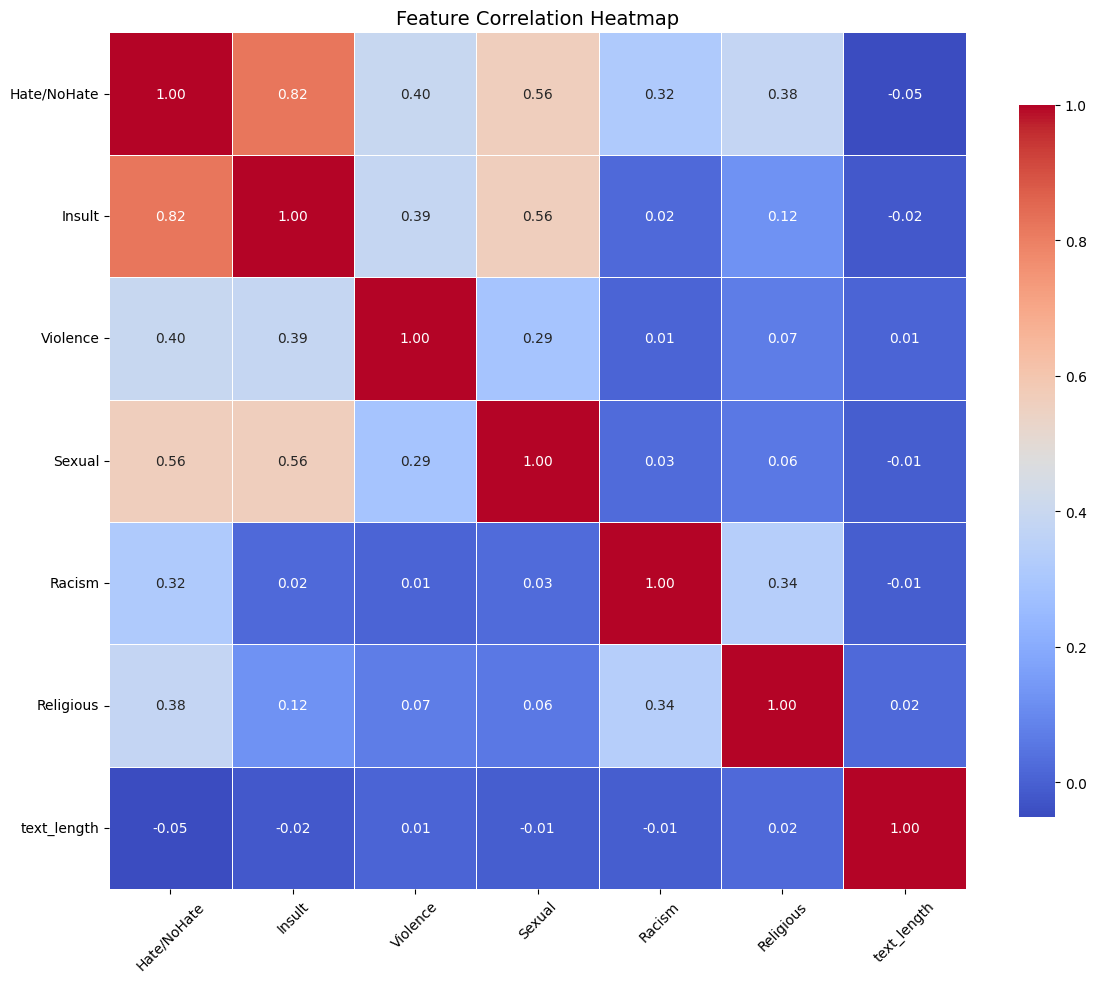

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = [
    'Hate/NoHate',
    'Insult',
    'Violence',
    'Sexual',
    'Racism',
    'Religious',
    'text_length'   # if already created
]

corr = dataset[numeric_cols].corr()
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:

def clean_text(text):
    text = str(text)
    text = re.sub(r'[^ঀ-\u09FF\s]', '', text)  # Bengali only
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dataset['clean_text'] = dataset['Comment'].apply(clean_text)

dataset.dropna(inplace=True)
dataset.drop_duplicates(subset='clean_text', inplace=True)

label_cols = ['Hate/NoHate', 'Insult', 'Violence', 'Sexual', 'Racism', 'Religious']
print(dataset[label_cols].sum())


Hate/NoHate    13800
Insult         10739
Violence        3270
Sexual          6039
Racism          2182
Religious       3093
dtype: int64


In [ ]:


dataset['text_length'] = dataset['clean_text'].apply(len)

stats = {
    "Mean": np.mean(dataset['text_length']),
    "Median": np.median(dataset['text_length']),
    "Variance": np.var(dataset['text_length']),
    "Std Dev": np.std(dataset['text_length']),
    "Skewness": skew(dataset['text_length']),
    "Min": np.min(dataset['text_length']),
    "Max": np.max(dataset['text_length']),
    "Percentiles": np.percentile(dataset['text_length'], [25,50,75])
}

for k,v in stats.items():
    print(k, ":", v)


Mean : 78.01843104297679
Median : 48.0
Variance : 14328.73626446408
Std Dev : 119.70269948695426
Skewness : 8.4616314080523
Min : 0
Max : 3101
Percentiles : [27. 48. 86.]


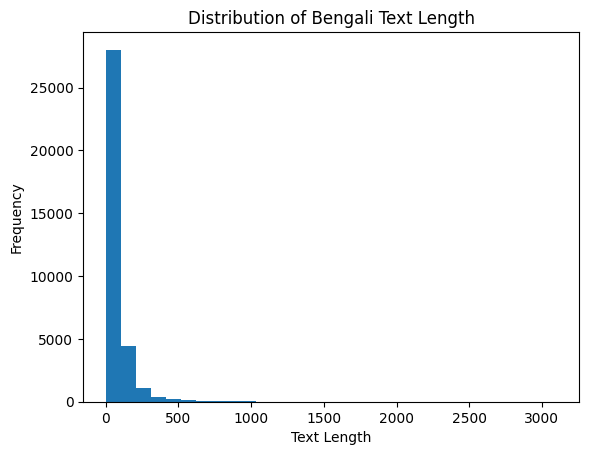

In [ ]:
plt.hist(dataset['text_length'], bins=30)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Bengali Text Length")
plt.show()


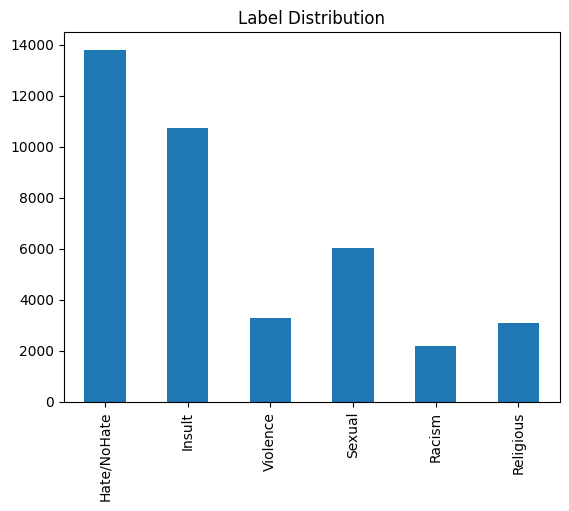

In [ ]:
dataset[label_cols].sum().plot(kind='bar')
plt.title("Label Distribution")
plt.show()


Data Preprocessing


Separating features and target, scaling the numeric values, and training.

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))


In [ ]:
dataset['tokens'] = dataset['clean_text'].apply(lambda x: x.split())


In [ ]:
X = dataset['clean_text']
X_tok = dataset['tokens']
y = dataset[label_cols]

X_train, X_test, X_train_tok, X_test_tok, y_train, y_test = train_test_split(
    X, X_tok, y, test_size=0.2, random_state=42
)

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Model Training

In [ ]:
fasttext_model = FastText(
    sentences=X_train_tok,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1
)


In [ ]:
def sentence_vector(tokens, model, size=100):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(size)

X_train_ft = np.array([sentence_vector(t, fasttext_model) for t in X_train_tok])
X_test_ft = np.array([sentence_vector(t, fasttext_model) for t in X_test_tok])

In [ ]:
X_train_final = hstack([X_train_tfidf, X_train_ft])
X_test_final = hstack([X_test_tfidf, X_test_ft])


In [ ]:
model = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=300, random_state=42)
)

model.fit(X_train_final, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                     random_state=42))

In [ ]:
scores = cross_val_score(
    model,
    X_train_final,
    y_train,
    cv=10,
    scoring='f1_micro'
)

print("10-Fold CV Scores:", scores)
print("Mean CV Score:", scores.mean())


10-Fold CV Scores: [0.74283601 0.74640619 0.77062031 0.7510277  0.75977654 0.7565123
 0.75525498 0.74648928 0.75351591 0.75246479]
Mean CV Score: 0.7534904027407698


In [ ]:
y_pred = model.predict(X_test_final)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2711
           1       0.82      0.66      0.73      2120
           2       0.83      0.45      0.59       657
           3       0.91      0.49      0.64      1170
           4       0.99      0.88      0.93       419
           5       1.00      0.64      0.78       575

   micro avg       0.87      0.66      0.75      7652
   macro avg       0.90      0.65      0.74      7652
weighted avg       0.87      0.66      0.74      7652
 samples avg       0.29      0.25      0.27      7652



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def predict_binary(text):
    prediction = predict_labels(text)
    return "Hate Speech" if prediction.sum() > 0 else "No Hate Speech"


In [ ]:
def predict_labels(text):
    text = clean_text(text)
    tfidf_vec = tfidf.transform([text])
    ft_vec = sentence_vector(text.split(), fasttext_model).reshape(1, -1)
    final_vec = hstack([tfidf_vec, ft_vec])
    return model.predict(final_vec)


In [ ]:
import numpy as np

label_cols = ['Insult', 'Violence', 'Sexual', 'Racism', 'Religious']

def predict_hate_or_not(text):
    prediction = predict_labels(text)

    # For multi-label output
    if np.any(prediction == 1):
        detected_labels = [label_cols[i] for i, val in enumerate(prediction[0]) if val == 1]
        print("🚨 Hate Speech Detected")
        print("Detected Categories:", detected_labels)
    else:
        print("✅ No Hate Speech Detected")


তুই একটা বাজে মানুষ

In [ ]:
predict_hate_or_not("এক এক যুগে বাংলাদেশ একেকটা হিরোকে ধ্বংস করছে	")


✅ No Hate Speech Detected


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


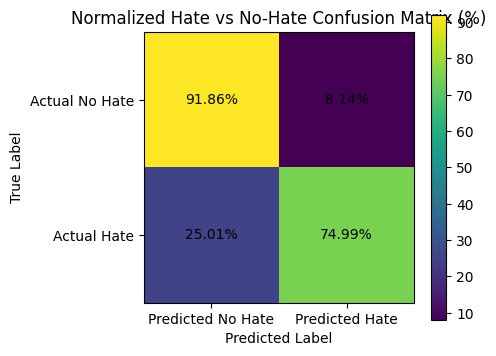

In [ ]:
cm_hate = cm[0]
cm_norm = cm_hate.astype('float') / cm_hate.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(5,4))
plt.imshow(cm_norm)
plt.colorbar()

plt.xticks([0, 1], ['Predicted No Hate', 'Predicted Hate'])
plt.yticks([0, 1], ['Actual No Hate', 'Actual Hate'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}%",
                 ha='center', va='center')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Hate vs No-Hate Confusion Matrix (%)")
plt.tight_layout()
plt.show()


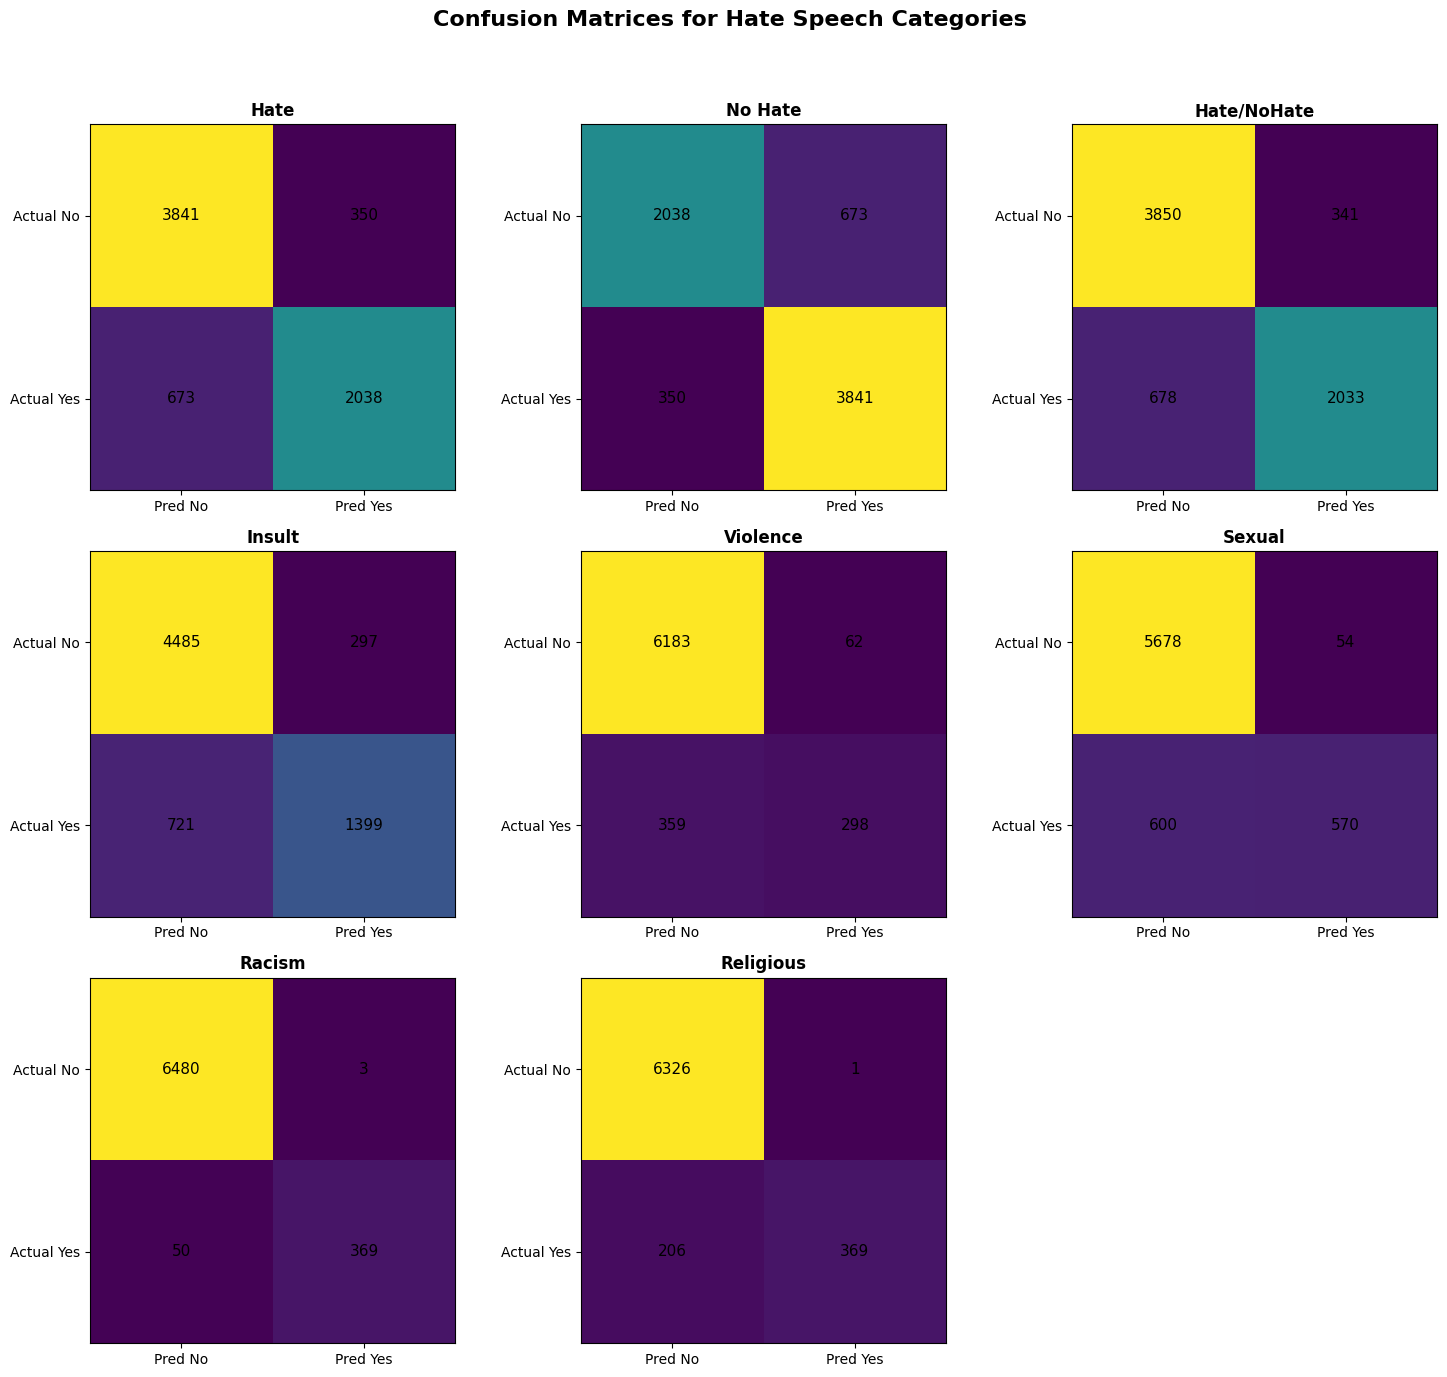

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
# Multi-label confusion matrices
ml_cm = multilabel_confusion_matrix(y_test, y_pred)

# Hate / No-Hate labels
y_test_hate = (y_test.sum(axis=1) > 0).astype(int)
y_pred_hate = (y_pred.sum(axis=1) > 0).astype(int)

y_test_nohate = (y_test.sum(axis=1) == 0).astype(int)
y_pred_nohate = (y_pred.sum(axis=1) == 0).astype(int)

cm_hate = confusion_matrix(y_test_hate, y_pred_hate)
cm_nohate = confusion_matrix(y_test_nohate, y_pred_nohate)
all_labels = ['Hate', 'No Hate'] + label_cols
all_matrices = [cm_hate, cm_nohate] + list(ml_cm)

fig, axes = plt.subplots(3, 3, figsize=(15, 14))
axes = axes.flatten()

for idx, (ax, label, cm) in enumerate(zip(axes, all_labels, all_matrices)):
    im = ax.imshow(cm)

    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

    ax.set_xticklabels(['Pred No', 'Pred Yes'])
    ax.set_yticklabels(['Actual No', 'Actual Yes'])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center', fontsize=11)

# Remove empty subplots
for i in range(len(all_matrices), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Confusion Matrices for Hate Speech Categories", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def compute_metrics_from_cm(cm):
    TN, FP, FN, TP = cm.ravel()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = (2 * precision * recall / (precision + recall)
                 if (precision + recall) > 0 else 0)

    return precision, recall, f1

results = []

# Hate
p, r, f = compute_metrics_from_cm(cm_hate)
results.append(['Hate', p, r, f])

# No Hate
p, r, f = compute_metrics_from_cm(cm_nohate)
results.append(['No Hate', p, r, f])

# Multi-label categories
for i, label in enumerate(label_cols):
    p, r, f = compute_metrics_from_cm(ml_cm[i])
    results.append([label, p, r, f])
metrics_df = pd.DataFrame(
    results,
    columns=['Label', 'Precision', 'Recall', 'F1-Score']
)

metrics_df[['Precision', 'Recall', 'F1-Score']] = \
    metrics_df[['Precision', 'Recall', 'F1-Score']].round(4)

print(metrics_df)


         Label  Precision  Recall  F1-Score
0         Hate     0.8534  0.7518    0.7994
1      No Hate     0.8509  0.9165    0.8825
2  Hate/NoHate     0.8564  0.7499    0.7996
3       Insult     0.8249  0.6599    0.7332
4     Violence     0.8278  0.4536    0.5860
5       Sexual     0.9135  0.4872    0.6355
6       Racism     0.9919  0.8807    0.9330
7    Religious     0.9973  0.6417    0.7810


In [ ]:
labels_all = ['Hate', 'No Hate'] + label_cols
cms_all = [cm_hate, cm_nohate] + list(ml_cm)

TP, FP, FN, support = [], [], [], []

for cm in cms_all:
    tn, fp, fn, tp = cm.ravel()
    TP.append(tp)
    FP.append(fp)
    FN.append(fn)
    support.append(tp + fn)  # actual positives
TP = np.array(TP)
FP = np.array(FP)
FN = np.array(FN)
support = np.array(support)
#macro average
precision_macro = np.mean(TP / (TP + FP + 1e-9))
recall_macro    = np.mean(TP / (TP + FN + 1e-9))
f1_macro        = np.mean(
    2 * TP / (2 * TP + FP + FN + 1e-9)
)
#micro average
TP_micro = TP.sum()
FP_micro = FP.sum()
FN_micro = FN.sum()

precision_micro = TP_micro / (TP_micro + FP_micro + 1e-9)
recall_micro    = TP_micro / (TP_micro + FN_micro + 1e-9)
f1_micro        = 2 * precision_micro * recall_micro / (
                    precision_micro + recall_micro + 1e-9
                  )
#weighted average
precision_weighted = np.sum(support * (TP / (TP + FP + 1e-9))) / support.sum()
recall_weighted    = np.sum(support * (TP / (TP + FN + 1e-9))) / support.sum()
f1_weighted        = np.sum(
    support * (2 * TP / (2 * TP + FP + FN + 1e-9))
) / support.sum()

# display result
avg_df = pd.DataFrame({
    'Average Type': ['Macro', 'Micro', 'Weighted'],
    'Precision': [precision_macro, precision_micro, precision_weighted],
    'Recall':    [recall_macro, recall_micro, recall_weighted],
    'F1-Score':  [f1_macro, f1_micro, f1_weighted]
})

avg_df[['Precision', 'Recall', 'F1-Score']] = \
    avg_df[['Precision', 'Recall', 'F1-Score']].round(4)

print(avg_df)


  Average Type  Precision  Recall  F1-Score
0        Macro     0.8895  0.6927    0.7688
1        Micro     0.8597  0.7501    0.8012
2     Weighted     0.8624  0.7501    0.7940


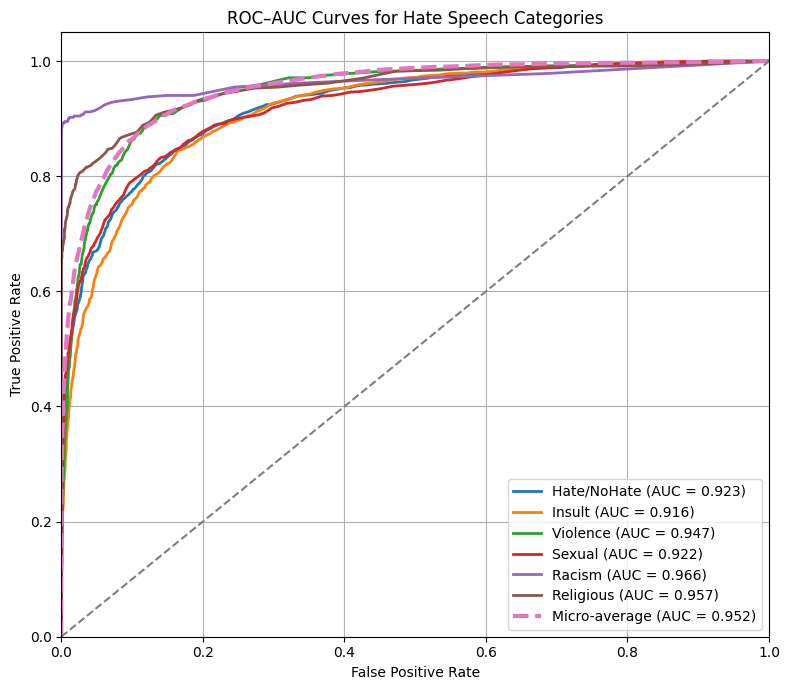

In [ ]:
from sklearn.metrics import roc_curve, auc
# Convert predict_proba output to array (n_samples, n_labels)
y_score_arr = y_prob
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, label in enumerate(label_cols):
    fpr[label], tpr[label], _ = roc_curve(y_test.iloc[:, i], y_score_arr[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test.values.ravel(),
    y_score_arr.ravel()
)

roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(8, 7))

# Plot per-label ROC
for label in label_cols:
    plt.plot(
        fpr[label],
        tpr[label],
        lw=2,
        label=f'{label} (AUC = {roc_auc[label]:.3f})'
    )

# Plot micro-average ROC
plt.plot(
    fpr["micro"],
    tpr["micro"],
    linestyle='--',
    linewidth=3,
    label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})'
)

# Diagonal line
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curves for Hate Speech Categories')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_prob = model.predict_proba(X_test_final)
from sklearn.metrics import roc_auc_score

roc_auc_micro = roc_auc_score(y_test, y_prob, average='micro')
roc_auc_macro = roc_auc_score(y_test, y_prob, average='macro')

print("ROC-AUC (Micro):", roc_auc_micro)
print("ROC-AUC (Macro):", roc_auc_macro)



ROC-AUC (Micro): 0.9521944747586357
ROC-AUC (Macro): 0.9385473492887729
